# *Gender Bias in Virtual Assistants Project*

### Identificando Preconceitos de Gênero em Assistentes Virtuais

![From Google](https://media-assets-01.thedrum.com/cache/images/thedrum-prod/s3-news-tmp-145694-untitled_design_70--default--1280.png)

### Equipe formada por
- Bárbara Stéphanie Neves Oliveira, 507526
- Lucas Benjamim Cunha Bandeira, 507533
- Samir Braga Chaves, 513788
- Vinicius Bernardo Gabriel, 475210


# *Wikipedia Toxic Comments Dataset* 

![Kaggle - Toxic Comment Classification Challenge](https://drive.google.com/uc?id=1AJGWaL4FYfc-Jm_s8EF4NO3EwrpRvG9o)

---

### Descrição do WTC *Dataset*

O *dataset* possui um grande número de comentários do Wikipédia rotulados manualmente com 7 classes.

- **Sumário:**
> - 4 arquivos (estamos usando os arquivos `train.csv`, `test.csv` e `test_labels.csv`)
  - Possui 52.63 MB de tamanho



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Imports

In [2]:
!pip install transformers scikit-multilearn

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# Pré-processamento de textos
import string
from spacy.lang.en import STOP_WORDS

CMAP_ICEFIRE = plt.get_cmap('icefire')
DEFAULT_FONT_SIZE = 14
plt.rcParams['font.size'] = DEFAULT_FONT_SIZE

BASE_PATH = '/content/drive/MyDrive/Ciência de Dados/Projeto Final'
DATASETS_PATH = BASE_PATH + "/Resources/Datasets"

In [4]:
# Adicionando módulos customizados ao path
import sys
import warnings
warnings.filterwarnings('ignore')

sys.path.append(BASE_PATH + '/Modules')
import utils, text
from importlib import reload

# Leitura dos Dados

In [5]:
train_df = pd.read_csv(DATASETS_PATH + '/Wikipedia Toxic Comments/train.csv')
test_df = pd.read_csv(DATASETS_PATH + '/Wikipedia Toxic Comments/test.csv')
test_labels_df = pd.read_csv(DATASETS_PATH + '/Wikipedia Toxic Comments/test_labels.csv')

len(train_df), (len(test_df), len(test_labels_df))

(159571, (153164, 153164))

In [6]:
# Realizando o merge dos textos e das labels baseado em id's iguais
test_df = pd.merge(test_df, test_labels_df, on='id')

# Segundo a página do Kaggle, o valor -1 indica que a label não foi usada para pontuação
# Desta forma, iremos substituir os valores de -1 por 0
test_df.update(test_df.loc[:, list(test_df.columns[-6:])].replace({-1: 0}))

# Concatenando os dados de treino e teste
df = train_df.append(test_df, ignore_index=True)

df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [7]:
print('Número de instâncias = {}'.format(len(df)))
print('Número de atributos = {}'.format(len(df.columns)))

Número de instâncias = 312735
Número de atributos = 8


# Pré-processamento dos Dados

Como já realizamos uma análise exploratória do **WTC *dataset*** e guardamos algumas informações especificamente para a etapa de pré-processamento, executaremos os seguintes passos para treinamento e avaliação dos modelos com o presente conjunto de dados: 

1. Tratamento dos dados desbalanceados 
2. Limpeza dos dados e remoção das *stopwords*
3. Seleção de uma *sample* para treino e avaliação com base em um *threshold* 



## Dados Desbalanceados

Como visto no *notebook* de EDA, o WTC *dataset* possui dados desbalanceados e uma quantidade grande de textos, cerca de 313 mil. Para lidar com estes tipos de dados, usaremos uma técnica chamada *under-sampling* (subamostragem), que equilibra o conjunto de dados reduzindo o tamanho da classe abundante. Este método é usado quando a quantidade de dados é mais do que suficiente. Ao manter todas as amostras na classe rara e selecionar aleatoriamente um número igual de amostras na classe abundante, o novo conjunto de dados balanceado pode então ser usado para treinamento e avaliação de modelos [[1](https://www.kdnuggets.com/2017/06/7-techniques-handle-imbalanced-data.html)]. 

<center>
  <img width="300" src="https://miro.medium.com/max/335/1*YH_vPYQEDIW0JoUYMeLz_A.png" />
</center>

Iremos fazer uso desta abordagem porque, além de tudo, nossos dados são multirótulo. Aplicar a técnica de *under-sampling* para esse tipo de dado é algo bastante complexo e, pelo o que sabemos, não existe nem sequer uma função pronta. O método criado neste *notebook* levará em conta o que já sabemos sobre os dados visto na parte de EDA. 

Primeiramente, trazemos para cá uma das visualizações presentes no *notebook* de EDA, que consiste em mostrar a distribuição dos comentários por quantidade de rótulos. Cada *subplot* contém a quantidade de ocorrências dos rótulos para os textos anotados com apenas 1 rótulo, com 2 rótulos, 3, e assim sucessivamente.

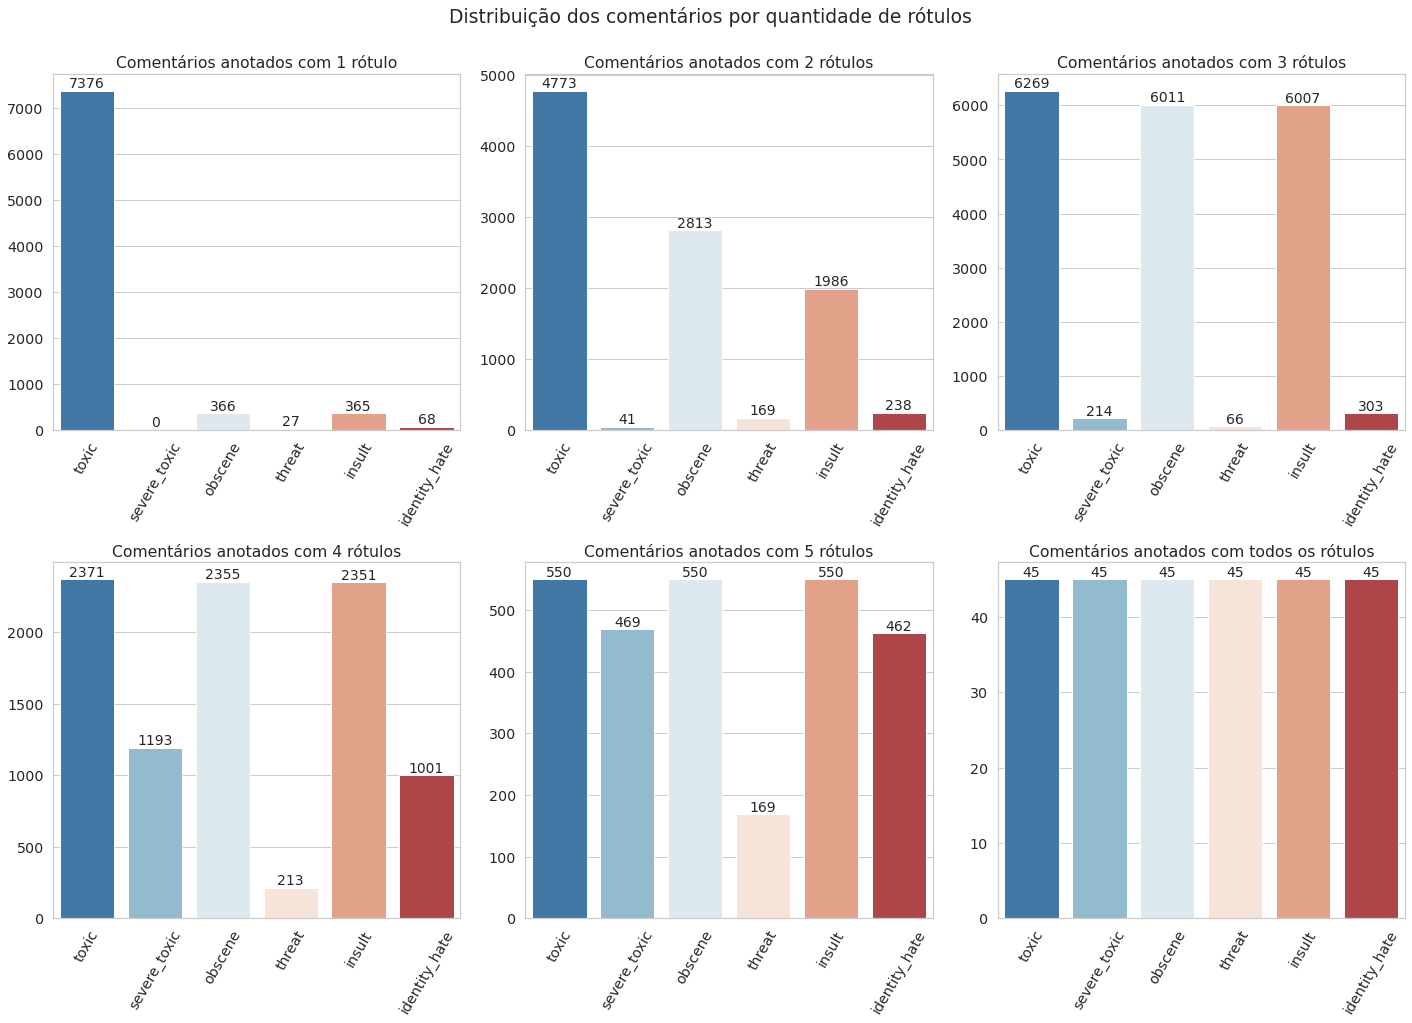

In [8]:
labels = list(df.columns[-6:])
labels_count = df[labels].sum().to_numpy() 

# Contando a quantidade de labels para cada um dos textos
df['labels_count'] = df[labels].sum(axis=1)
# Caso o texto não possua nenhum rótulo tóxico, então ele é safe
df['if_safe'] = df['labels_count'] == 0

labels_count_each = []
for i in range(1, 7):
  max_i = df[df['labels_count'] == i]
  labels_count_each.append(max_i[labels].sum().to_numpy())
labels_count_each = np.array(labels_count_each)

utils.plot_histogram_labels_count_each(x_label=labels, 
                                       y_label=labels_count_each, 
                                       labels=labels_count_each, 
                                       palette='RdBu_r',
                                       title='Distribuição dos comentários por quantidade de rótulos',
                                       width=20,
                                       height=15)

Como as primeiras 5 distribuições são desbalanceadas e como temos muitos dados, seguiremos os seguintes passos: 

1. Para cada uma das distribuições (se anotados com 1 rótulo, 2, 3, etc., e menos a última, que já está balanceada), obteremos o valor da quantidade de ocorrências da 3ª classe rara, para reduzir o tamanho apenas das classes majoritárias.
2. Para cada rótulo de cada distribuição, selecionaremos aleatóriamente *n samples*, sendo *n* o valor da quantidade de ocorrências da classe rara em questão.
3. Juntaremos essas *samples* com a da distribuição balanceada e visualizaremos a quantidade de ocorrências de cada rótulo.
4. Caso o gráfico esteja um pouco mais balanceado, selecionaremos uma quantidade proporcial dos comentários `safe` para fazer parte deste novo conjunto de dados.

In [9]:
labels_count_each_thold = {i + 1: sorted(set(v))[2] for i, v in enumerate(labels_count_each[:-1])}

print('Valores escolhido para cada distribuição por quantidade de rótulos =')
labels_count_each_thold

Valores escolhido para cada distribuição por quantidade de rótulos =


{1: 68, 2: 238, 3: 303, 4: 1193, 5: 469}

In [10]:
final_df = df[df['labels_count'] == 6]
print('Tamanho inicial do final_df = {}\n'.format(len(final_df)))

for index in range(1, 6):
  print('Obtendo os comentários anotados com {} rótulo(s)...'.format(index))
  df_labels_count_each = df[df['labels_count'] == index]
  print('Selecionando aproximadamente {} samples do rótulo:'.format(int(labels_count_each_thold[index])))
  for label in labels[:-1]:
    total_sample_len = len(df_labels_count_each.loc[df_labels_count_each[label] == 1])
    sample_len = int(labels_count_each_thold[index])
    
    if(total_sample_len < sample_len):
      sample_len = total_sample_len
    aux_df = df_labels_count_each[df_labels_count_each[label] == 1].sample(sample_len, random_state=42)
    print('-> {}'.format(label))
    print('   Quantidade de dados a serem acrescentados ao final_df = {}'.format(len(aux_df)))
    final_df = final_df.append(aux_df, ignore_index=True)
    print('   Tamanho do final_df = {}'.format(len(final_df)))
  print('\n')

final_df.head()

Tamanho inicial do final_df = 45

Obtendo os comentários anotados com 1 rótulo(s)...
Selecionando aproximadamente 68 samples do rótulo:
-> toxic
   Quantidade de dados a serem acrescentados ao final_df = 68
   Tamanho do final_df = 113
-> severe_toxic
   Quantidade de dados a serem acrescentados ao final_df = 0
   Tamanho do final_df = 113
-> obscene
   Quantidade de dados a serem acrescentados ao final_df = 68
   Tamanho do final_df = 181
-> threat
   Quantidade de dados a serem acrescentados ao final_df = 27
   Tamanho do final_df = 208
-> insult
   Quantidade de dados a serem acrescentados ao final_df = 68
   Tamanho do final_df = 276


Obtendo os comentários anotados com 2 rótulo(s)...
Selecionando aproximadamente 238 samples do rótulo:
-> toxic
   Quantidade de dados a serem acrescentados ao final_df = 238
   Tamanho do final_df = 514
-> severe_toxic
   Quantidade de dados a serem acrescentados ao final_df = 41
   Tamanho do final_df = 555
-> obscene
   Quantidade de dados a serem

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,labels_count,if_safe
0,02c6e41e4b317ac3,WOULDN'T BE THE FIRST TIME BITCH. FUCK YOU I'L...,1,1,1,1,1,1,6,False
1,039296aa294ee10b,"SHUT UP, YOU FAT POOP, OR I WILL KICK YOUR ASS!!!",1,1,1,1,1,1,6,False
2,1368c10281978876,"You're a stupid cunt \n\nFuck you dumb arse, y...",1,1,1,1,1,1,6,False
3,2405c66d017f139e,Bitch \n\nYou are a little bitch. I fuckin spe...,1,1,1,1,1,1,6,False
4,24d2b50726b67167,I am going to murder ZimZalaBim ST47 for being...,1,1,1,1,1,1,6,False


In [11]:
dups = final_df.duplicated()
print('Número de linhas duplicadas = {}'.format(dups.sum()))

print('Número de instâncias = {}'.format(len(final_df)))

# Excluindo as linhas duplicadas
final_df.drop_duplicates(inplace=True)
print('Número de instâncias após a remoção = {}'.format(len(final_df)))

Número de linhas duplicadas = 4380
Número de instâncias = 9419
Número de instâncias após a remoção = 5039


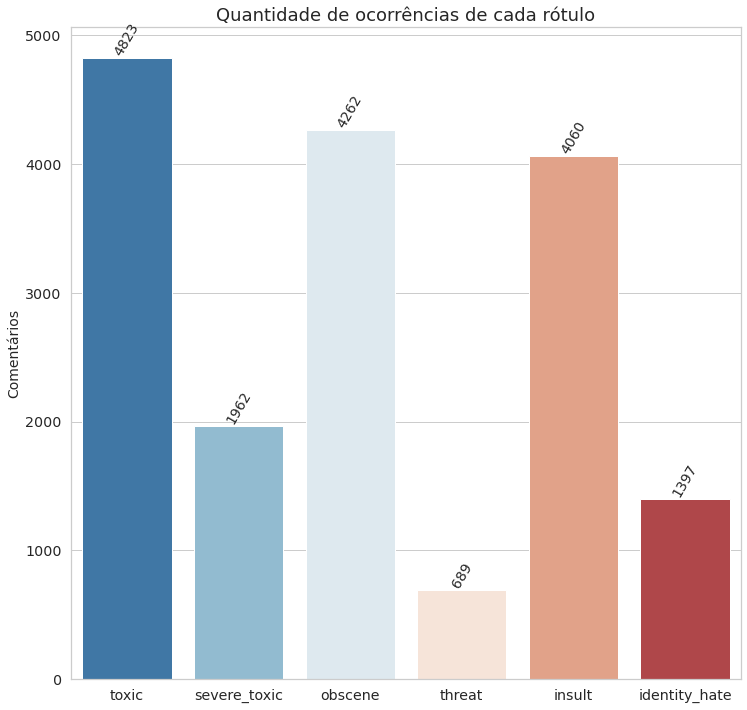

In [12]:
new_labels_count = final_df[labels].sum().to_numpy()

utils.plot_histogram_labels(x_label=labels, 
                            y_label=new_labels_count, 
                            labels=new_labels_count, 
                            palette='RdBu_r',
                            title='Quantidade de ocorrências de cada rótulo', 
                            ylabel_title='Comentários', 
                            width=12,
                            height=12)

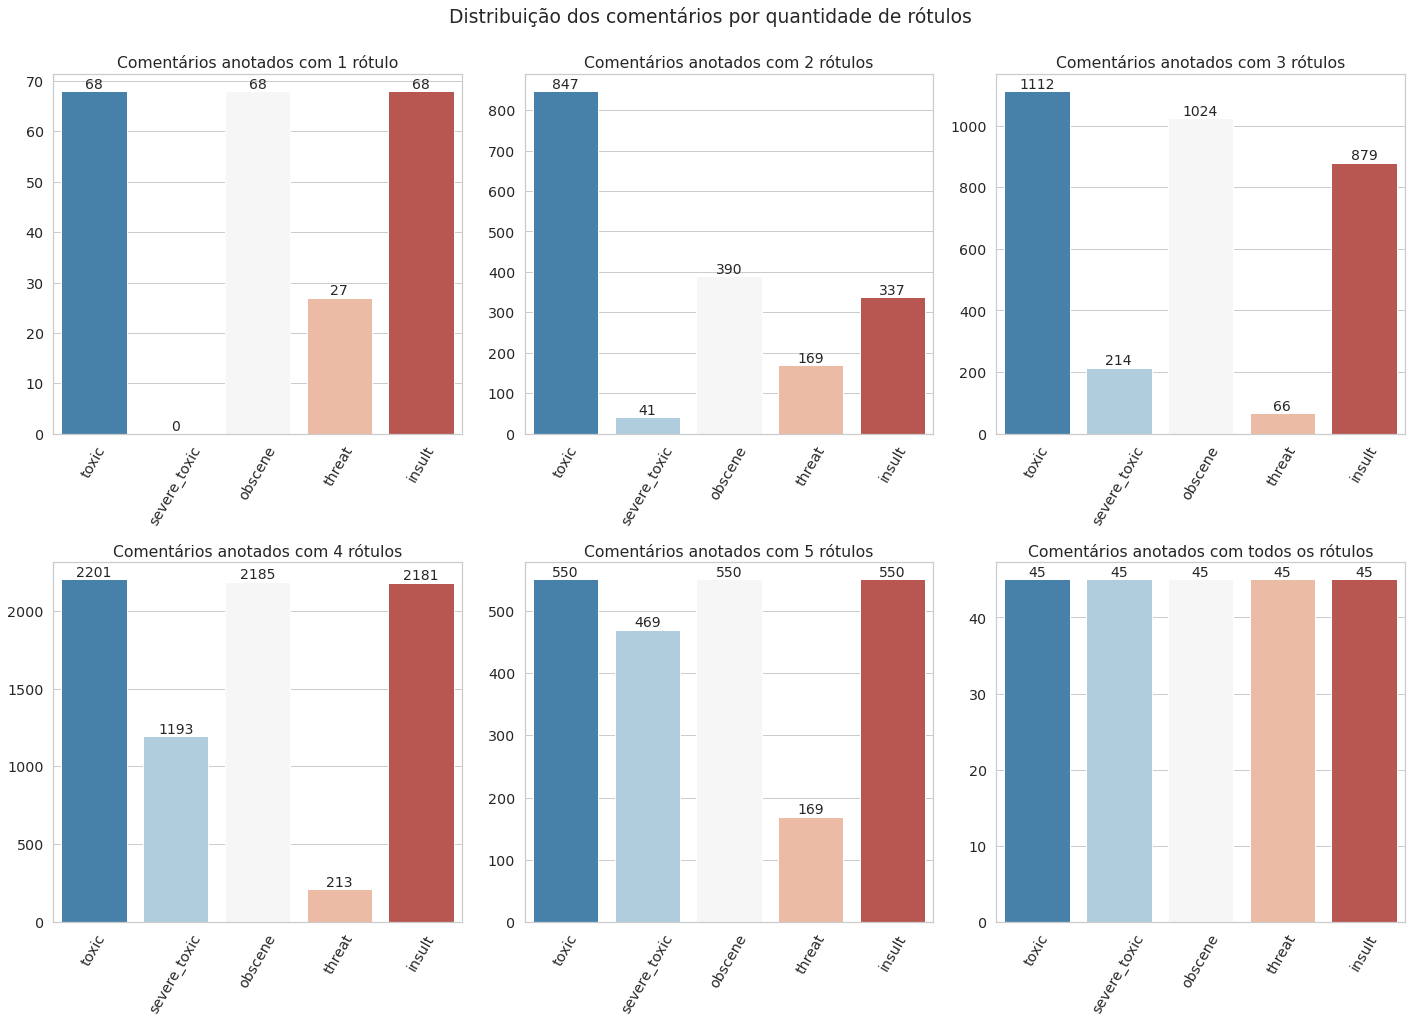

In [13]:
new_labels_count_each = []
for i in range(1, 7):
  max_i = final_df[final_df['labels_count'] == i]
  new_labels_count_each.append(max_i[labels[:-1]].sum().to_numpy())
new_labels_count_each = np.array(new_labels_count_each)

utils.plot_histogram_labels_count_each(x_label=labels[:-1], 
                                       y_label=new_labels_count_each, 
                                       labels=new_labels_count_each, 
                                       palette='RdBu_r',
                                       title='Distribuição dos comentários por quantidade de rótulos',
                                       width=20,
                                       height=15)

In [14]:
# Unindo o final_df com uma quantidade proporcional de dados safe
safe_len = new_labels_count.sum() # Soma das ocorrências dos rótulos tóxicos
df = final_df.append(df[df['if_safe']].sample(safe_len, random_state=42), ignore_index=True)

print('Número de instâncias = {}'.format(len(df)))

Número de instâncias = 22232


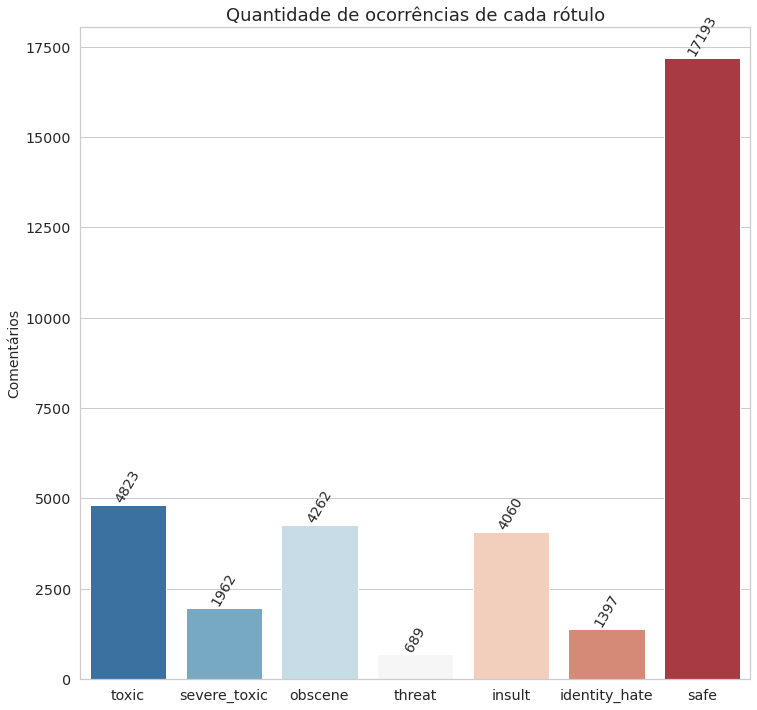

In [15]:
new_labels_count = np.append(new_labels_count, safe_len)

utils.plot_histogram_labels(x_label=labels + ['safe'], 
                            y_label=new_labels_count, 
                            labels=new_labels_count, 
                            palette='RdBu_r',
                            title='Quantidade de ocorrências de cada rótulo', 
                            ylabel_title='Comentários', 
                            width=12,
                            height=12)

## Limpeza dos Dados e Remoção das *Stopwords*

Nesta etapa, iremos repetir o que foi feito no *notebook* de EDA.

In [16]:
df['comment_text_tokens'] = df['comment_text'].apply(lambda r: r.translate(str.maketrans('', '', string.punctuation)).lower().split()) 
df['clean_comment_text'] = df['comment_text_tokens'].apply(lambda x: ' '.join(x))
df['comment_text_tokens_count'] = df['comment_text_tokens'].apply(lambda r: len(r)) # Quantidade de tokens de cada texto

all_comment_tokens = df['comment_text_tokens'].explode() 
all_comment_clean_tokens = [token for token in all_comment_tokens if token not in STOP_WORDS]

most_common_clean_tokens = utils.make_most_common_words(all_comment_clean_tokens, n_most_common=50)
words2ignore = [tup[0] for tup in most_common_clean_tokens if tup[1] > 20000] # Valor que estava no notebook de EDA
set_stop_words2ignore = STOP_WORDS.union(set(words2ignore))

df['comment_text_tokens'] = df['comment_text_tokens'].apply(lambda x: text.remove_potencial_stopwords(x, words2ignore=set_stop_words2ignore))
df['clean_comment_text_words2ignore'] = df['comment_text_tokens'].apply(lambda x: ' '.join(x))

df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,labels_count,if_safe,comment_text_tokens,clean_comment_text,comment_text_tokens_count,clean_comment_text_words2ignore
0,02c6e41e4b317ac3,WOULDN'T BE THE FIRST TIME BITCH. FUCK YOU I'L...,1,1,1,1,1,1,6,False,"[wouldnt, time, bitch, fuck, ill, find, live, ...",wouldnt be the first time bitch fuck you ill f...,28,wouldnt time bitch fuck ill find live sodomize...
1,039296aa294ee10b,"SHUT UP, YOU FAT POOP, OR I WILL KICK YOUR ASS!!!",1,1,1,1,1,1,6,False,"[shut, fat, poop, kick, ass]",shut up you fat poop or i will kick your ass,11,shut fat poop kick ass
2,1368c10281978876,"You're a stupid cunt \n\nFuck you dumb arse, y...",1,1,1,1,1,1,6,False,"[youre, stupid, cunt, fuck, dumb, arse, mum, h...",youre a stupid cunt fuck you dumb arse your mu...,59,youre stupid cunt fuck dumb arse mum hairy cun...
3,2405c66d017f139e,Bitch \n\nYou are a little bitch. I fuckin spe...,1,1,1,1,1,1,6,False,"[bitch, little, bitch, fuckin, spent, 6, hours...",bitch you are a little bitch i fuckin spent 6 ...,94,bitch little bitch fuckin spent 6 hours big sa...
4,24d2b50726b67167,I am going to murder ZimZalaBim ST47 for being...,1,1,1,1,1,1,6,False,"[going, murder, zimzalabim, st47, evil, homose...",i am going to murder zimzalabim st47 for being...,12,going murder zimzalabim st47 evil homosexual jews


In [17]:
print('Estatísticas básicas da contagem de tokens dos comentários =\n{}\n'.format(df['comment_text_tokens_count'].describe()))

# Todos os tokens dos comentários
all_comment_tokens = df['comment_text_tokens'].explode() 

print('Quantidade de palavras de todos os comentários = {}'.format(len(list(all_comment_tokens))))
print('Quantidade de palavras ÚNICAS de todos os comentários = {}'.format(len(set(all_comment_tokens))))

Estatísticas básicas da contagem de tokens dos comentários =
count    22232.000000
mean        62.233042
std        108.356909
min          0.000000
25%         13.000000
50%         29.000000
75%         65.000000
max       1403.000000
Name: comment_text_tokens_count, dtype: float64

Quantidade de palavras de todos os comentários = 682912
Quantidade de palavras ÚNICAS de todos os comentários = 69943


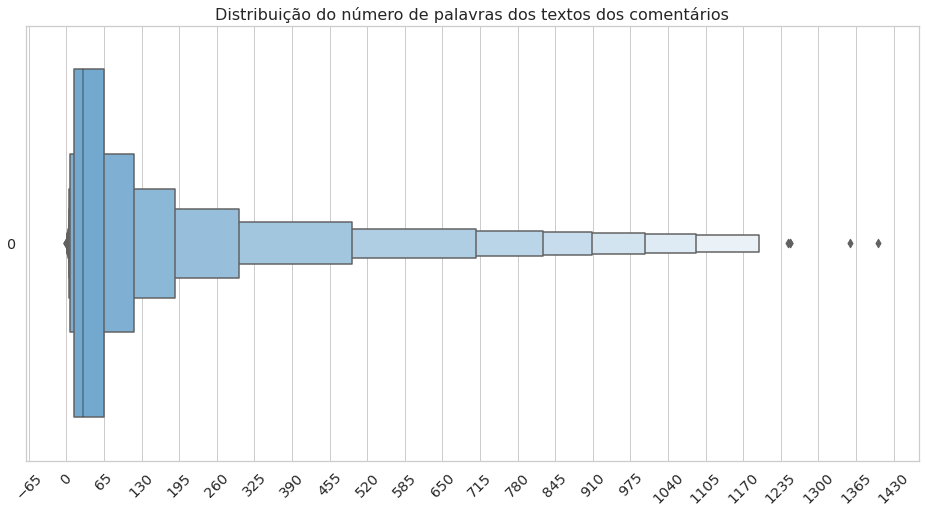

In [18]:
comment_tokens_percentil_75 = df['comment_text_tokens_count'].describe()['75%']

utils.plot_distribution_large_data(df['comment_text_tokens_count'], 
                                   title='Distribuição do número de palavras dos textos dos comentários', 
                                   xaxis_interval=comment_tokens_percentil_75)

## *Sample* Final dos Dados

Aqui, iremos selecionar mais uma *sample* do conjunto de dados. Como o intuito final do presente trabalho consiste em unir as predições de dois modelos diferentes (um para identificação de viés de gênero e outro para toxicidade), precisamos escolher um valor de *threshold* para o tamanho dos textos. Este valor também é usado no *notebook* de pré-processamento para os *datasets* anotados conforme o gênero. Nossos modelos precisam receber textos que possuam uma quantidade de palavras proporcional.

- Valor do *threshold* = até 60 palavras

In [19]:
print('Número de instâncias = {}'.format(len(df)))

df = df[df['comment_text_tokens_count'] > 1] # Retirando textos que possuem apenas uma palavra (ou nenhuma)
df = df[df['comment_text_tokens_count'] <= text.MAX_LENGTH]
print('Número de instâncias após a remoção = {}'.format(len(df)))

Número de instâncias = 22232
Número de instâncias após a remoção = 16188


In [20]:
df.to_csv('/content/drive/MyDrive/Ciência de Dados/Projeto Final/Resources/Datasets/Wikipedia Toxic Comments/new_data.csv', index=False)

# Observações 

*Só isso de pré-processamento? E a representação textual? E os rótulos? Ficam assim mesmo?*

Paciência, gafanhoto. Quem espera sempre alcança! 

No que diz respeito aos rótulos, eles estão no formato ideal. Enquanto que os textos ainda precisam passar por algumas mudanças para serem usados como entrada para os modelos. Este passo será feito na etapa de treinamento ;)

# Referência

[[1](https://www.kdnuggets.com/2017/06/7-techniques-handle-imbalanced-data.html)] 7 Techniques to Handle Imbalanced Data. 2017. KDnuggets. Ye Wu & Rick Radewagen, IE Business School.